In [3]:
import torch
import numpy as np
import csv
import random
import math
import matplotlib

import matplotlib.pyplot as plt

%matplotlib inline

#import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import copy
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torch.optim as optim
from torch import utils
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(2)
CUDA_LAUNCH_BLOCKING=1
#torch.autograd.set_detect_anomaly(True)
print (use_cuda)

torch.backends.cudnn.enabled
import os


import time

True


In [4]:
import argparse
import os
import shutil
import sys
import time

In [5]:
import numpy as np
import torch
import torch.nn as nn
from sklearn import metrics
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [6]:
from cgcnn.data import CIFData
from cgcnn.data import collate_pool
from cgcnn.model import CrystalGraphConvNet

In [9]:
from ase import Atoms
from ase.calculators.emt import EMT
from ase.db import connect


from clease.tools import update_db
from clease import Concentration
from clease import CEBulk
from clease import Evaluate
from clease import NewStructures
from clease.calculator import Clease
from clease.calculator import attach_calculator

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

import json
with open('agpd_dft_eci_ref.json') as json_file: 
    eci = json.load(json_file) 
    
conc = Concentration(basis_elements=[['Ag', 'Pd']])
settings = CEBulk(crystalstructure='fcc',
                   a=4.09,
                   size=[3,3,3],
                   concentration=conc,
                   db_name="auni_ar.db",
                   max_cluster_size=4,
                   max_cluster_dia=[8.0, 6.5, 5.5])

atoms = settings.atoms.copy()
atoms = attach_calculator(settings, atoms=atoms, eci=eci)

k_b = 0.00008617

def get_concentrations(lattices):
    lattices = ((lattices+1)/2).view(lattices.shape[0],-1)
    Ag_conc = torch.sum(lattices,dim=1)/(27)
    return Ag_conc

In [11]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ase.io.trajectory import TrajectoryWriter
from ase.io import read
from ase.io import iread
from ase.io import write

lst = []
for i in range(1250):
    name = 'batch_template_1250_3x3x3/structure_num' + str(i) + '.cif'
    for j in range(len(atoms.numbers)):
        rd = np.random.rand()
        if rd > 0.5:
            atoms.numbers[j] = 46
        else:
            atoms.numbers[j] = 47
    
    print(atoms)
    write(name,atoms)
    
    curr_entry = []
    curr_entry.append('structure_num' + str(i))
    curr_entry.append(0)
    lst.append(curr_entry)
    
df = pd.DataFrame(lst)
file = 'batch_template_1250_3x3x3/id_prop.csv'
df.to_csv(file, header=None, index=False)

Atoms(symbols='AgPd3Ag2PdAg3Pd4AgPdAg2PdAg3Pd3Ag2', pbc=True, cell=[[0.0, 6.135, 6.135], [6.135, 0.0, 6.135], [6.135, 6.135, 0.0]], tags=..., calculator=Clease(...))
Atoms(symbols='PdAg3Pd2Ag2Pd3AgPdAg2PdAg5Pd2Ag3Pd', pbc=True, cell=[[0.0, 6.135, 6.135], [6.135, 0.0, 6.135], [6.135, 6.135, 0.0]], tags=..., calculator=Clease(...))
Atoms(symbols='PdAg3PdAgPdAg4PdAgPd2Ag2PdAg2Pd2Ag4Pd', pbc=True, cell=[[0.0, 6.135, 6.135], [6.135, 0.0, 6.135], [6.135, 6.135, 0.0]], tags=..., calculator=Clease(...))
Atoms(symbols='PdAg2Pd3AgPdAg5Pd5Ag2PdAgPdAg2Pd2', pbc=True, cell=[[0.0, 6.135, 6.135], [6.135, 0.0, 6.135], [6.135, 6.135, 0.0]], tags=..., calculator=Clease(...))
Atoms(symbols='AgPd2Ag4PdAgPdAgPdAg3PdAgPd2AgPdAg2PdAgPd2', pbc=True, cell=[[0.0, 6.135, 6.135], [6.135, 0.0, 6.135], [6.135, 6.135, 0.0]], tags=..., calculator=Clease(...))
Atoms(symbols='AgPdAgPd3AgPd3AgPd2Ag2Pd2AgPd2Ag5PdAg', pbc=True, cell=[[0.0, 6.135, 6.135], [6.135, 0.0, 6.135], [6.135, 6.135, 0.0]], tags=..., calculator=Clea

In [12]:
parser = argparse.ArgumentParser(description='Crystal gated neural networks')
parser.add_argument('modelpath', help='path to the trained model.')
parser.add_argument('cifpath', help='path to the directory of CIF files.')
parser.add_argument('-b', '--batch-size', default=1250, type=int,
                    metavar='N', help='mini-batch size (default: 100)')
parser.add_argument('-j', '--workers', default=0, type=int, metavar='N',
                    help='number of data loading workers (default: 0)')
parser.add_argument('--disable-cuda', action='store_true',
                    help='Disable CUDA')
parser.add_argument('--print-freq', '-p', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')

args = parser.parse_args(['model_best_alt_new.pth.tar','batch_template_1250_3x3x3'])

if os.path.isfile(args.modelpath):
    print("=> loading model params '{}'".format(args.modelpath))
    model_checkpoint = torch.load(args.modelpath,
                                  map_location=lambda storage, loc: storage)
    model_args = argparse.Namespace(**model_checkpoint['args'])
    print("=> loaded model params '{}'".format(args.modelpath))
else:
    print("=> no model params found at '{}'".format(args.modelpath))

args.cuda = not args.disable_cuda and torch.cuda.is_available()


=> loading model params 'model_best_alt_new.pth.tar'
=> loaded model params 'model_best_alt_new.pth.tar'


In [13]:
dataset = CIFData('batch_template_1250_3x3x3',radius = 12,max_num_nbr = 24)
collate_fn = collate_pool
test_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True,
                         num_workers=args.workers, collate_fn=collate_fn,
                         pin_memory=args.cuda)

structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]
energy_model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len=model_args.atom_fea_len,
                            n_conv=model_args.n_conv,
                            h_fea_len=model_args.h_fea_len,
                            n_h=model_args.n_h,
                            classification=True if model_args.task ==
                            'classification' else False)
if args.cuda:
    energy_model.cuda()


/home/james/miniconda3/envs/james_mlmat/lib/python3.7/site-packages/pymatgen/io/cif.py:1123: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [14]:
energy_model.eval()

for i, (input, target, batch_cif_ids) in enumerate(test_loader):
    with torch.no_grad():
        if args.cuda:
            input_var = (Variable(input[0].cuda(non_blocking=True)),
                         Variable(input[1].cuda(non_blocking=True)),
                         input[2].cuda(non_blocking=True),
                         [crys_idx.cuda(non_blocking=True) for crys_idx in input[3]])

In [15]:
import copy

ag_key = copy.deepcopy(input_var[0][0])
ag_key = ag_key.view(1,92)
ag_key_large = ag_key.expand(33750,-1)
pd_key = copy.deepcopy(input_var[0][74])
pd_key = pd_key.view(1,92)
pd_key_large = pd_key.expand(33750,-1)

        

In [16]:
class Normalizer(object):
    """Normalize a Tensor and restore it later. """
    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

In [17]:
print(args.modelpath)
normalizer = Normalizer(torch.zeros(3))
if os.path.isfile(args.modelpath):
    print("=> loading model '{}'".format(args.modelpath))
    checkpoint = torch.load(args.modelpath,
                            map_location=lambda storage, loc: storage)
    energy_model.load_state_dict(checkpoint['state_dict'])
    normalizer.load_state_dict(checkpoint['normalizer'])
    print("=> loaded model '{}' (epoch {}, validation {})"
          .format(args.modelpath, checkpoint['epoch'],
          checkpoint['best_mae_error']))
 

model_best_alt_new.pth.tar
=> loading model 'model_best_alt_new.pth.tar'
=> loaded model 'model_best_alt_new.pth.tar' (epoch 154, validation 1.5135937929153442)


In [18]:
def get_graph_energies(lattices):
    
    batch_size = lattices.shape[0]
    lattices = lattices.view(-1)
    size = lattices.shape[0]
    ag_sites = torch.abs(((lattices + 1)/2).view(-1,1).expand(size,92))
    pd_sites = (torch.abs(1 - lattices)/2).view(-1,1).expand(size,92)
    
    ids = torch.abs(ag_sites * ag_key_large + pd_sites * pd_key_large)
    inp = (Variable(ids.cuda(non_blocking=True)),input_var[1],input_var[2],input_var[3])
    energies = energy_model(*inp)
    energies = normalizer.denorm(energies.data)
    
    return (27*energies).view(batch_size)

In [19]:

###### Based off Wu et Al. Solving Statistical Mechanics Using Variational Autoregressive Networks


def KL_loss(DBG,lattices,epoch,temp,field,num_temps,num_fields):
    lattices = lattices.detach()
    probs = DBG.get_sample_prob(lattices,temp,field,epoch).view(lattices.shape[0])
    with torch.no_grad():
        energies = DBG.get_energies(lattices).view(lattices.shape[0])
        energies_norm = energies.view(-1)/(temp.view(-1)*k_b)
       
        F = (energies_norm + probs).view(-1,1)
        F_new = F - (field.view(-1,1) * lattices.view(-1,DBG.Nz).sum(dim=1).view(-1,1))/(k_b*temp.view(-1,1))
        
        batch = int(lattices.shape[0]/(num_temps*num_fields))
        F_mean = F_new.view(-1,num_fields).view(num_temps,-1,num_fields)
        
        F_mean = F_mean.mean(dim=1).view(num_temps,1,num_fields).expand(num_temps,batch,num_fields)
        R = (F_new.view(-1) - F_mean.reshape(-1))/torch.abs(F_mean.reshape(-1))
        
    
    assert not R.requires_grad
    assert probs.requires_grad
    return torch.mean(R*probs)

In [20]:
temps_sim = [200,375,550,725,900]
field_sim = [-0.2,-0.1,0.0,0.1,0.2]
temp_temp = [0]
field_temp = [0]
coordinate_cutoff = 4.0
def train_model(model,optimizer,batch_size,epochs,temp_type,chem_type,temp_range):
    field_sim = [-0.2,-0.1,0.0,0.1,0.2]
    if temp_range == 'Large':
        temps_sim = [100,300,500,700,900]
    else:
        temps_sim = [200,375,550,725,900]
    epoch = 0
    temp = torch.zeros(len(temps_sim)*batch_size).cuda()
    field = torch.zeros(len(temps_sim)*batch_size).cuda()

    print_log_header()

    while epoch < epochs:
        if temp_type == 'Random Single':
            num_temps = 1
            t = temps_sim[0] + (temps_sim[-1]-temps_sim[0])*np.random.rand()
            for i in range(len(temps_sim)*batch_size):
                temp[i] = t
        elif temp_type == 'Random':
            t_fixed = []
            for i in range(5):
                t_temp = temps_sim[0] + (temps_sim[-1]-temps_sim[0])*np.random.rand()
                t_fixed.append(t_temp)
            num_temps = 5
            for i in range(len(temps_sim)*batch_size):
                temp[i] = t_fixed[int(i/batch_size)]
        else:
            num_temps = 5
            for i in range(len(temps_sim)*batch_size):
                temp[i] = temps_sim[int(i/batch_size)]
            
        if chem_type == 'Random Single':
            num_fields = 1
            f = -0.2 * 0.4*np.random.rand()
            for i in range(len(temps_sim)*batch_size):
                field[i] = f
        elif chem_type == 'Random':
            f_fixed = []
            for i in range(5):
                f_temp = -0.2 * 0.4*np.random.rand()
                f_fixed.append(f_temp)
            num_fields = 5
            for i in range(len(temps_sim)*batch_size):
                field[i] = f_fixed[int(i%(len(field_sim)))]
        else:
            num_fields = 5
            for i in range(len(temps_sim)*batch_size):
                field[i] = field_sim[int(i%(len(field_sim)))]
        
        epoch = epoch + 1

        lattices = model.forward(temp,field)
        
        if epoch % 1000 == 0:
            print("training...")
        
        kl_loss = KL_loss(model,lattices,epoch,temp,field,num_temps,num_fields)
        
        optimizer.zero_grad()
        kl_loss.backward()
        optimizer.step()
            
       
    return model

In [21]:
def print_log_header():
    print ('{:>8} {:>12}'\
       .format('epoch','train loss'))
    
def print_training_log(epoch, train_loss, test_loss=None):
    if test_loss is not None:
        print ('{:>8} {:>8} {:>12.4f} {:>12.4f}'\
                   .format(epoch, train_loss, test_loss))
        f.write('{:>8} {:>8} {:>12.4f} {:>12.4f}\n'\
                   .format(epoch, train_loss, test_loss))
    else:
        print ('{:>8} {:>8}'\
                   .format(epoch, train_loss))

In [22]:
def one_hot_to_sites(lattices,Nz):
    lattices = lattices.view(-1,Nz,2)
    lattices = torch.argmax(lattices,dim=2)
    lattices = 2*lattices - 1.0
    lattices = lattices.view(-1,Nz)
    return lattices.float()
    
def sites_to_one_hot(lattices):
    lattices = lattices.view(lattices.shape[0],-1)
    lattices = (0.5*(lattices + 1)).long()
    one_hot_lattices = torch.zeros(lattices.shape[0],lattices.shape[1],2).float().cuda()
    one_hot_lattices = one_hot_lattices.scatter_(2,lattices.view(lattices.shape[0],-1,1),1.0)
    return one_hot_lattices.detach()

In [23]:
def mask_weight(m,disp):
    num_sites = m.shape[1]
    num_components = 2
    mask = torch.zeros(m.shape)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if (disp == 0):
                if (j == 0 or j == 1 ):
                    mask[i,j] = 1.0
                elif ((j-2) < num_components*int(i/num_components) ):
                    mask[i,j] = 1.0
            if (disp == 1):
                if (j == 0 or j==1 ):
                    mask[i,j] = 1.0
                if ((j-2) < num_components*int(i/num_components) + num_components):
                    mask[i,j] = 1.0
    mask = mask.detach()
    m_masked = m*mask
    return m_masked

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [24]:
class autoreg_model(nn.Module):
    def __init__(self,Nz,assignments):
        super().__init__()
        self.Nz = Nz
        self.Dim = int(math.sqrt(Nz))
        self.assignments = assignments
        self.activation = activation_functions[assignments['activation']]
        self.lsoftmax = torch.nn.LogSoftmax(dim=2)
        self.softmax = torch.nn.Softmax(dim=2)
        self.num_layers = int(assignments['Layers'])
        
        self.shared_layer = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer.weight,0))
        self.mask_1 = mask_weight(torch.ones_like(self.shared_layer.weight),0).cuda()
        
        self.shared_layer.weight.register_hook(get_zero_grad_hook(self.mask_1))
        
        
        self.shared_layer_2 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_2.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_2.weight,1))
        self.mask_2 = mask_weight(torch.ones_like(self.shared_layer_2.weight),1).cuda()
        
        self.shared_layer_2.weight.register_hook(get_zero_grad_hook(self.mask_2))
        
        self.shared_layer_3 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_3.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_3.weight,1))
        self.mask_3 = mask_weight(torch.ones_like(self.shared_layer_3.weight),1).cuda()
        
        self.shared_layer_3.weight.register_hook(get_zero_grad_hook(self.mask_3))
        
        self.shared_layer_4 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_4.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_4.weight,1))
        self.mask_4 = mask_weight(torch.ones_like(self.shared_layer_4.weight),1).cuda()
        
        self.shared_layer_4.weight.register_hook(get_zero_grad_hook(self.mask_4))
        
    def get_sample_prob(self,lattices,temp,field,epoch):
        #print(self.shared_layer.weight)
        
        batch_size = temp.shape[0]
        samples = sites_to_one_hot(lattices).view(batch_size,-1)
        net_in = torch.cat((field.view(-1,1)*10,samples),dim=1)
        net_in = torch.cat((temp.view(-1,1)/1000,net_in),dim=1)
        conditional = self.activation(self.shared_layer(net_in))
        conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
        conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
        conditional = self.shared_layer_2(conditional)
        if self.num_layers > 2:
            conditional = self.activation(conditional)
            conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
            conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
            conditional = self.shared_layer_3(conditional)
            
        if self.num_layers > 3:
            conditional = self.activation(conditional)
            conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
            conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
            conditional = self.shared_layer_4(conditional)
        
        conditional = conditional.view(-1,self.Nz,2)
        
        Probs = self.lsoftmax(conditional)
        samples = samples.detach()
        assert Probs.requires_grad == True
        site_prob = Probs*(samples.view(-1,self.Nz,2))
        probs = torch.sum(torch.sum(site_prob,dim=2),dim=1)
        return probs
        
    def forward(self,temp,field):
        
        batch_size = temp.shape[0]
        temp = temp.view(-1,1)
        field = field.view(-1,1)
        lattices = torch.zeros(batch_size,2*self.Nz).cuda()
        for site in range(self.Nz):
            net_in = torch.cat((field*10,lattices),dim=1)
            net_in = torch.cat((temp/1000,net_in),dim=1)
            conditional = self.activation(self.shared_layer(net_in))
            conditional = torch.cat((field*10,conditional),dim=1)
            conditional = torch.cat((temp/1000,conditional),dim=1)
            conditional = self.shared_layer_2(conditional)
            if self.num_layers > 2:
                conditional = self.activation(conditional)
                conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
                conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
                conditional = self.shared_layer_3(conditional)
            
            if self.num_layers > 3:
                conditional = self.activation(conditional)
                conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
                conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
                conditional = self.shared_layer_4(conditional)
            
            conditional = conditional.view(-1,self.Nz,2)
            Probs = self.softmax(conditional)
            To_Sample = Probs[:,site,:]
            sample = torch.multinomial(To_Sample,1).view(-1,1)
            lattices = lattices.view(-1,self.Nz,2)
            lattices[:,site,:] = lattices[:,site,:].scatter_(1,sample,1)
            lattices = lattices.view(-1,2*self.Nz)
        #print(lattices.requires_grad)
        lattices = one_hot_to_sites(lattices,self.Nz)
        return lattices

def create_model(Nz,assignments):
    class Discrete_Boltzmann_Generator(nn.Module):
        def __init__(self,Nz,assignments):
            super().__init__()
            self.Nz = Nz
            self.Dim = int(math.sqrt(Nz))
            self.assignment = assignments
            self.Model = autoreg_model(Nz,assignments)
            atoms.numbers = np.ones((self.Nz))*46
            self.U_pd = atoms.get_potential_energy()
            atoms.numbers = np.ones((self.Nz))*47
            self.U_ag = atoms.get_potential_energy()
            
        def forward(self,temp,field):
            return self.Model.forward(temp,field)
            
        def get_energies(self,lattices):
            return get_graph_energies(lattices)
           
        
        def get_sample_prob(self,sample,temp,field,epoch):
            return self.Model.get_sample_prob(sample,temp,field,epoch)
        
    model = Discrete_Boltzmann_Generator(Nz,assignments).cuda()
    temp_range = assignments['temp_range']
    batch_size = int(assignments['batch_size'])
    optimizer = optimizers[assignments['optimizer']](model.parameters(), lr=10**assignments['log_learning_rate'])
    epochs = assignments['epochs']
    temp_type = assignments['temp_type']
    chem_type = assignments['Chem_type']
    model = train_model(model,optimizer,batch_size,epochs,temp_type,chem_type,temp_range)
    
    return model

In [25]:
class Discrete_Boltzmann_Generator(nn.Module):
    def __init__(self,Nz,assignments):
        super().__init__()
        self.Nz = Nz
        self.Dim = int(math.sqrt(Nz))
        self.assignment = assignments
        self.Model = autoreg_model(Nz,assignments)
        atoms.numbers = np.ones((self.Nz))*46
        self.U_pd = atoms.get_potential_energy()
        atoms.numbers = np.ones((self.Nz))*47
        self.U_ag = atoms.get_potential_energy()
            
    def forward(self,temp,field):
        return self.Model.forward(temp,field)
            
    def get_energies(self,lattices):
        return get_graph_energies(lattices)
           
        
    def get_sample_prob(self,sample,temp,field,epoch):
        return self.Model.get_sample_prob(sample,temp,field,epoch)

In [26]:
activation_functions = {
    'relu': nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'tanh': nn.Tanh(),
}

optimizers = {
    'gradient_descent': optim.SGD,
    'rmsprop': optim.RMSprop,
    'adam': optim.Adam,
}


Dim = 3

In [27]:
assignments = {
  "Chem_type": "Fixed",
  "Layers": "3",
  "activation": "sigmoid",
  "batch_size": "250",
  "epochs": 17228.762093926078,
  "log_learning_rate": -2.524528017542186,
  "optimizer": "adam",
  "temp_range": "Small",
  "temp_type": "Random"
}

In [ ]:
start = time.time()
model = create_model(27,assignments)
end = time.time()

   epoch   train loss
training...
training...
training...


In [26]:
print(end-start)

7203.200485706329


In [52]:
torch.save(model.state_dict(), "AgPdCGC_27")

In [28]:
model = Discrete_Boltzmann_Generator(27,assignments)

In [47]:
load_params = torch.load("AgPdCGC_27")



In [50]:
model.Model.shared_layer.weight = nn.Parameter(load_params["Model.shared_layer.weight"])
model.Model.shared_layer_2.weight = nn.Parameter(load_params["Model.shared_layer_2.weight"])
model.Model.shared_layer_3.weight = nn.Parameter(load_params["Model.shared_layer_3.weight"])
model.Model.shared_layer_4.weight = nn.Parameter(load_params["Model.shared_layer_4.weight"])

In [51]:
model.cuda()

Discrete_Boltzmann_Generator(
  (Model): autoreg_model(
    (activation): Sigmoid()
    (lsoftmax): LogSoftmax(dim=2)
    (softmax): Softmax(dim=2)
    (shared_layer): Linear(in_features=56, out_features=54, bias=False)
    (shared_layer_2): Linear(in_features=56, out_features=54, bias=False)
    (shared_layer_3): Linear(in_features=56, out_features=54, bias=False)
    (shared_layer_4): Linear(in_features=56, out_features=54, bias=False)
  )
)

In [52]:
def examine_phase(model,lattices,tmp,temp_b,field_b,Ag_conc):
    #print(lattices)
    
    log_rw = torch.zeros(lattices.shape[0],lattices.shape[1]).cuda()
    for k in range(8):
        prob = model.get_sample_prob(lattices[k,:,:],temp_b,field_b,1000).view(-1)
        with torch.no_grad():
            
            energies = (model.get_energies(lattices[k,:,:])/(tmp*k_b)).view(-1)

            pot = -(field_b.view(-1)*lattices[k,:,:].sum(dim=1).view(-1))/(tmp*k_b)
            pot = energies+prob+pot
            log_rw[k,:] = -pot
        
    log_rw = log_rw.view(-1)
            
    stored = log_rw.mean()
    log_rw_corr = log_rw - stored
    rw = torch.exp(log_rw_corr)
        
    
    rw_norm = rw/(rw.sum())
    est_part = torch.exp(log_rw_corr).mean()
    log_z = torch.log(est_part)+stored
    conc_mean = (Ag_conc.view(-1)*rw_norm.view(-1)).sum().cpu().detach().numpy().item()
    var = torch.sum((rw_norm**2)*(Ag_conc-conc_mean)**2)
    conc_var = (var).cpu().detach().numpy()
    gp = -k_b*tmp*log_z
    return conc_mean,conc_var,gp,0

In [53]:
def get_conc_at_temp(temp):
    
    chemical_pots = np.linspace(-0.2,0.2,41)
    concs = np.linspace(-.2,.2,41)
    concs_rw = np.linspace(-.2,.2,41)
    concs_var = np.linspace(-.2,.2,41)
    free_energies = np.linspace(-.2,.2,41)
    iters = 4
    counter = 0
    for chpot in chemical_pots:
        for k in range(8):
            temps = torch.zeros(1250).cuda()
            fields = torch.zeros(1250).cuda()
            for i in range(1250):
                temps[i] = temp
                fields[i] = chpot
                
            lattices_temp = model.forward(temps,fields).view(1,-1,27)
            
            if k == 0:
                lattices = lattices_temp
            else:
                lattices = torch.cat((lattices_temp,lattices),dim=0)
            
        concs_iter = get_concentrations(lattices.view(-1,27)).view(-1)
        concs[counter] = concs_iter.mean().cpu().detach().numpy()
        
        conc_mean,conc_var,gp,energies = examine_phase(model,lattices,temp,temps,fields,concs_iter)
        free_energies[counter] = gp
        concs_var[counter] = conc_var
        concs_rw[counter] = conc_mean
        counter = counter + 1
        
    return chemical_pots,concs,concs_rw,concs_var,free_energies

In [54]:
concs_sim_np = np.loadtxt(open("AgPd_CGC_np_new_250_750.csv", "rb"), delimiter=",", skiprows=0)


In [55]:
chemical_pots_low,concs_low,concs_rw_low,concs_var_low,fe_low = get_conc_at_temp(250)
chemical_pots_high,concs_high,concs_rw_high,concs_var_high,fe_high = get_conc_at_temp(750)

In [56]:
print(chemical_pots_low)

[-0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09
 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03
  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12  0.13  0.14  0.15
  0.16  0.17  0.18  0.19  0.2 ]


In [57]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#003f5c
#58508d
#bc5090
#ff6361
#ffa600
N = 5
newcolors = []
newcolors.append((0,63,92))
newcolors.append((88,80,141)) 
newcolors.append((188,80,144)) 
newcolors.append((255,99,97)) 
newcolors.append((255,166,0)) 

newcolors_norm = []
for i in newcolors:
    curr = np.asarray(i)
    print(curr)
    curr = curr/255.0
    curr = tuple(curr)
    newcolors_norm.append(curr)

cmap_name = 'my_list'
newcmp = LinearSegmentedColormap.from_list(cmap_name,newcolors_norm)

[ 0 63 92]
[ 88  80 141]
[188  80 144]
[255  99  97]
[255 166   0]


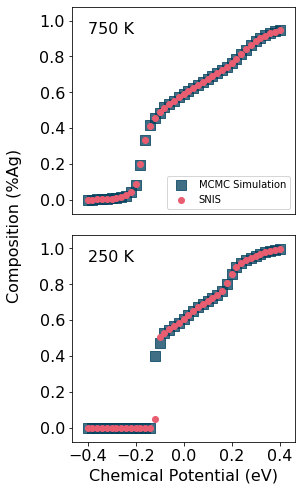

In [58]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'hspace': 0.1})
import matplotlib as mpl
import matplotlib.font_manager as font_manager
plt.rcParams["figure.figsize"] = (4,8)

mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
axs[0].scatter(chemical_pots_low*2.0,concs_sim_np[1,:],color=newcmp(0.0),label='MCMC Simulation',alpha=0.75,s = 100,marker='s')
axs[0].scatter(chemical_pots_low*2.0,concs_rw_high,color=newcmp(0.66666),label='SNIS',alpha=1.0)
axs[0].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axs[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
axs[0].tick_params(labelsize=16)
prop = font = font_manager.FontProperties(family='Arial',size=10)
axs[0].legend(loc = 4,prop=font)
axs[0].text(-0.4, 0.95, '750 K', fontsize = 16,fontname = "Arial",va='center', rotation='horizontal')

axs[1].scatter(chemical_pots_low*2.0,concs_sim_np[0,:],color=newcmp(0.0),alpha=0.75,s = 100,marker='s')
axs[1].scatter(chemical_pots_low*2.0,concs_rw_low,color=newcmp(0.6666666),alpha=1.0)
axs[1].text(-0.4, 0.95, '250 K', fontsize = 16,fontname = "Arial",va='center', rotation='horizontal')

axs[1].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axs[1].tick_params(labelsize=16)

plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname = "Arial")
plt.xticks([-0.4,-0.2,0.0,0.2,0.4])
fig.text(-0.1, 0.5, 'Composition (%Ag)', fontsize = 16,fontname = "Arial",va='center', rotation='vertical')
plt.xticks(fontsize = 16,fontname = "Arial") 

plt.savefig('ag_pd_concs_6_CGC_July_10.pdf',bbox_inches='tight')

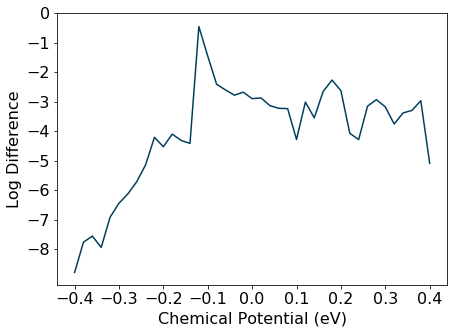

In [61]:
plt.plot(chemical_pots_low*2.0,np.log10(abs(concs_rw_low-concs_sim_np[0,:])),color=newcmp(0.0))
plt.rcParams["figure.figsize"] = (7,5)
mpl.rc('font',family='Arial')
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname="Arial")
plt.xticks([-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4])
plt.yticks([0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6,-7,-8])
plt.ylabel('Log Difference',fontsize=16,fontname="Arial")
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.savefig('AgPdError3_July_10.pdf',bbox_inches='tight')
    
plt.show()

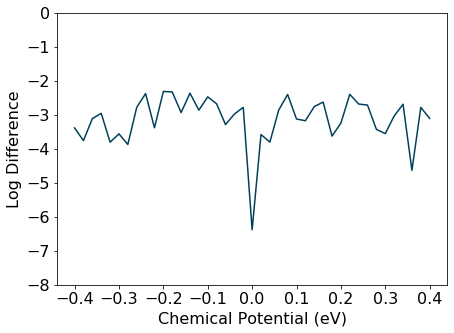

In [60]:
plt.plot(chemical_pots_low*2.0,np.log10(abs(concs_rw_high-concs_sim_np[1,:])),color=newcmp(0.0))

plt.rcParams["figure.figsize"] = (7,5)
mpl.rc('font',family='Arial')
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname="Arial")
plt.xticks([-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4])
plt.yticks([0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6,-7,-8])
plt.ylabel('Log Difference',fontsize=16,fontname="Arial")
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.savefig('AgPdError4_July_10.pdf',bbox_inches='tight')
    
plt.show()